# MNIST Dataset

## Introduction

We've now talked about why we need machine learning (some relationships are too complex to represent manually), we've looked at the different components of machine learning (model, parameters, loss functions, optimizers), implementing machine learning in a small scale application (linear regression with stochastic gradient descent), and how PyTorch gives us the tools to have more power over our machine learning. Now we are going to combine all of those ideas together to write a model which will identify hand written numbers for us.

### The Dataset

The MNIST dataset is a curated set of hand written numbers that is commonly used as a starting point for machine learning. The original dataset created by NIST (National Institute for Standards and Technology) was leveraged in various goverment tasks related to OCR (Optical Character Recognition). Think tasks like reading tax forms, postal addresses, other manual entry processes. MNIST is a subset of the dataset selected to be more ideal for machine learning with a more sophisticated test/training split. The dataset includes 60,000 images in the training set and 10,000 images in the test set.

### CNNs

Convolutional Neural Networks (CNNs) are a special kind of neural network designed for learning features what can assist in recognizing patterns in typically grid like data. They are inspired by how perception works in the brain, but like all neural networks are a simplifaction.

If we remember back to the template matching at the begining, for template matching to work, we need a good starting template. CNNs provide us a way to learn more complex features. Interestingly CNNs still effectivly apply a template matching like algorithm, but leveraging machine learning to learn the templates for us.

#### AlexNet

CNNs for object detection have been on of the widest applications of machine learning (before LLMs). AlexNet is a CNN developed at the University of Toronto to detect up to 1,000 distinct objects and is often times a starting point for making for specifically tuned CNNs since the heavy lifting of training a lot of the parameters has been taken care of by the team.

* For more information on the MNIST dataset: https://en.wikipedia.org/wiki/MNIST_database
* MNIST CNN Visualizer: https://adamharley.com/nn_vis/
* GoogLeNet Visualizer: https://distill.pub/2017/feature-visualization/

## Explore the Dataset

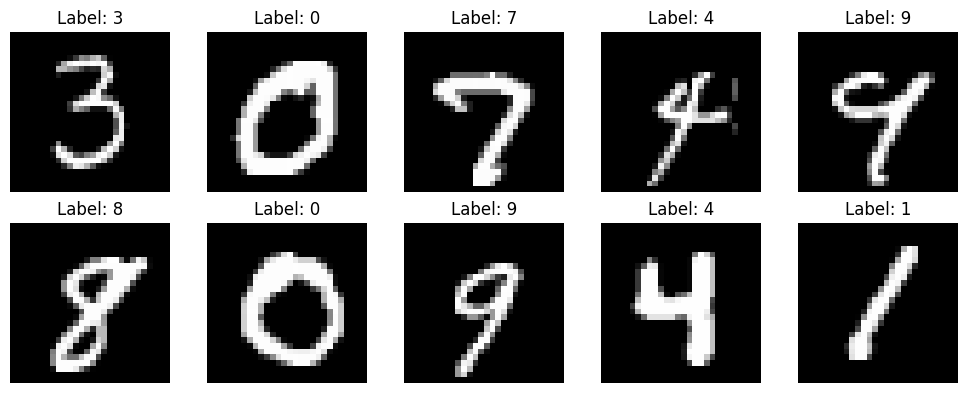

In [29]:
from torchvision import datasets, transforms
import torch
from matplotlib import pyplot as plt

# A series of operations that will apply to each image
# 1. Convert the image into a PyTorch tensor
# 2. Normalize the tensors to have a mean of 0.1307 and stand deviation of 0.3081
#    these are already known values for MNIST and is a common practice to normalize
#    data as it will stop the features we learn later on from out weighing each other
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Using PyTorch's built in data for MNIST, we are telling it to download the training set
train_set = datasets.MNIST('../data', train=True, download=True, transform=transform)

# The data loader then specifies how we can load in the downloaded images into Python
dataloader = torch.utils.data.DataLoader(train_set, batch_size=10)

# Function to display images taken from https://pythonguides.com/pytorch-mnist/
def show_images(images, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.flatten()

    for i in range(10):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Now we will pull out 10 images to look at
images, labels = next(iter(dataiter))

# Show images
show_images(images, labels)

## Creating the Model Structure

PyTorch comes with several layers/operations that will be really helpful fo us to build our NN.

Model being leveraged: https://github.com/pytorch/examples/blob/main/mnist/main.py

* Conv2D: https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

  Allows the for creating a convolution layer. The layer needs a few pieces of information.
  1. How many channels are coming in. This usually refers to things like colors in normal RGB images (which would be 3 channels)
  2. How many output channels, which will essentially be the number of different filters we will learn
  3. The size of each filter
* Dropout: https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html

  Lets us randomly "ignore" certain neurons. This is helpful to reduce the chance that the neurons learn features that are too similar or overfit.
* Linear: https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html

  Apply an affine linear transformation
* ReLu: https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html

  Activation function where the result is evaluated as the max(0, result from the neuron)
* Max Pooling: https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

  Provides a way to shrink the feature set into a smaller representation

* Log Soft Max:https://docs.pytorch.org/docs/2.8/generated/torch.nn.LogSoftmax.html

  

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # First convolution layer will have a single channel
        # the result will be 32 filters that will be learned
        # with each filter being a 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, 3, 1)

        # Second convolution layer that will take in the 32
        # filtered results and produce 64 filters with
        # each filter being a 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # One of the dropout operations we want to learn
        self.dropout1 = nn.Dropout(0.25)

        # A second dropout that is at a higher probability
        self.dropout2 = nn.Dropout(0.5)

        # First linear layer that will take 9216 features down to 128
        self.fc1 = nn.Linear(9216, 128)

        # Second linear layer that will take 128 features down to 10
        # This is very important because this represents the number 
        # of outputs (the digits 0 - 9)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First take the image and pass it through our first
        # convolution layer
        x = self.conv1(x)

        # Next apply the relu activation function
        x = F.relu(x)

        # Now pass the resulting filtered image through the
        # second convolution layer
        x = self.conv2(x)

        # Apply another relu activation function
        x = F.relu(x)

        # Down sample the resulting image following
        # a 2x2 max pool
        x = F.max_pool2d(x, 2)

        # Apply a drop out to reduce chance of 
        # over fitting
        x = self.dropout1(x)

        # We still have out data in a 2D format, but the output
        # is 1 dimensional (0 - 9). Flatten will make a single
        # dimensional input
        x = torch.flatten(x, 1)

        # Now that we have a 1D input, we can start to learn how to
        # turn our larger vector of features into a detection of
        # the digits 0-9
        x = self.fc1(x)

        # Use relu as the activation function again
        x = F.relu(x)

        # Apply the second drop out to again try to 
        # reduce the chance of overfitting
        x = self.dropout2(x)

        # The final linear layer that will bring down the features
        # to 10 in total
        x = self.fc2(x)

        # Finally we apply this log softmax
        # Soft max creates essentially a probabily 
        # distribution. We can think of it as "how likley is the input to be a given digit"
        output = F.log_softmax(x, dim=1)
        return output

In [51]:
import torch.optim as optim

train_data = datasets.MNIST(
    root='../data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_data = datasets.MNIST(
    root='../data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNN().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(loaders['test'].dataset)
    print(f"\nTest set: Average loss: {test_loss: 0.4f}, Accuracy {correct}/{len(loaders['test'].dataset)}  ({100 * correct / len(loaders['test'].dataset):.0f}%\n")



for epoch in range(1, 10):
    train(epoch)
    test()


Train Epoch: 1 [0/60000 (0%)]	Loss: -0.099682
Train Epoch: 1 [1000/60000 (2%)]	Loss: -0.117595
Train Epoch: 1 [2000/60000 (3%)]	Loss: -0.310387
Train Epoch: 1 [3000/60000 (5%)]	Loss: -0.427612
Train Epoch: 1 [4000/60000 (7%)]	Loss: -0.554570
Train Epoch: 1 [5000/60000 (8%)]	Loss: -0.527752
Train Epoch: 1 [6000/60000 (10%)]	Loss: -0.606336
Train Epoch: 1 [7000/60000 (12%)]	Loss: -0.682471
Train Epoch: 1 [8000/60000 (13%)]	Loss: -0.674687
Train Epoch: 1 [9000/60000 (15%)]	Loss: -0.694653
Train Epoch: 1 [10000/60000 (17%)]	Loss: -0.699086
Train Epoch: 1 [11000/60000 (18%)]	Loss: -0.742075
Train Epoch: 1 [12000/60000 (20%)]	Loss: -0.791396
Train Epoch: 1 [13000/60000 (22%)]	Loss: -0.753741
Train Epoch: 1 [14000/60000 (23%)]	Loss: -0.749037
Train Epoch: 1 [15000/60000 (25%)]	Loss: -0.757938
Train Epoch: 1 [16000/60000 (27%)]	Loss: -0.784126
Train Epoch: 1 [17000/60000 (28%)]	Loss: -0.731444
Train Epoch: 1 [18000/60000 (30%)]	Loss: -0.784849
Train Epoch: 1 [19000/60000 (32%)]	Loss: -0.715108